In [1]:
import os 
from pathlib import Path
import pandas as pd
import os
wd = Path.cwd().parent
path_to_data = [[wd / "input" / "rosenborg-women_a_2020.xlsx", wd / "input" / "rosenborg-women_a_2021.xlsx"],
                [wd / "input" / "vifwomen_a_2020.xlsx", wd / "input" / "vifwomen_a_2021.xlsx"]]
os.chdir(Path.cwd().parent)
from preprocessing.data_loader import generate_teams
from singular_spectrum_analysis.multi_dim_svd import TsSVD

In [2]:
from fancyimpute import KNN, SoftImpute

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
teams = generate_teams(path_to_data, ["VI", "Rosenborg"])
players = [player for player in teams["Rosenborg"].players.values()]+[player for player in teams["VI"].players.values()]

In [ ]:
readiness = pd.DataFrame([player.readiness for player in players])
missing_readiness = pd.DataFrame([player.readiness for player in players]).isnull()
ts = [series for _, series in missing_readiness.iterrows()]

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
dtw_k_means = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=10)
dtw_k_means.fit(missing_readiness)

In [ ]:
#fig, axs = plt.subplots(nrows=14, ncols=4, figsize=(50,25))
#color = ["orange" if label == 1 else "darkblue" if label ==2 else "darkgreen" if label== 3 else "red" if label== 4 else "purple" for label in dtw_k_means.labels_]
#for ax, readiness, label, c in zip(axs.ravel(), ts, dtw_k_means.labels_, color):
#    ax.plot(readiness, marker=".",color=c, label=f"{label}")
#    ax.legend()

In [ ]:
readiness_ = readiness.copy()
readiness_ = readiness_.reset_index(drop=True)
readiness_["label"] = dtw_k_means.labels_
cluster = readiness_.loc[readiness_["label"] == 1]

In [ ]:
%%capture
softimput = SoftImpute().fit_transform(readiness_.iloc[:,:-1])
decay_fitted = TsSVD.fit(readiness_.iloc[:,:-1].to_numpy(), 15)
mean_fitted = TsSVD.fit(readiness_.iloc[:,:-1].to_numpy(), 15, fill_with_decay=False)

In [ ]:
references = [series for _, series in readiness_.iterrows()]
#all_fit = all_fitted.matrix[cluster.index, :]
#softimputed = softimput[cluster.index, :]

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(50,25))
for ax, soft, row, reference, fit in zip(axs.ravel(), softimput, decay_fitted.matrix.tolist(), references, np.array(mean_fitted.matrix.tolist())):
    ax.plot(soft+20, color="orange", label="SoftImpute")
    ax.plot(row, color="darkblue", label="Cluster Fit")
    ax.plot(fit+10, color="green", label="Decay Fit")
    ax.plot(reference-10, color="red", label="Reference")
    ax.legend()

In [4]:
from random import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
climate = pd.read_csv(wd/"notebooks"/"DailyDelhiClimateTrain.csv", sep = ",").iloc[:1400,1:]
baseketball_acc = pd.read_csv(wd/"notebooks"/"acc.csv", sep = ";").iloc[:5000,:]
cycling = pd.read_csv(wd/"notebooks"/"cycling_data.csv", sep = ";")
standing = pd.read_csv(wd/"notebooks"/"sitting_data.csv", sep = ";")
motor_activity = pd.read_csv(wd/"notebooks"/"activity.csv",engine='python', sep = ",.").iloc[:1000,:-1]

In [12]:
%%capture
sotimpute_data = []
knn_data = []
pca_data = []
pca_data_decay = []
pca_mae = []
pca_mae_decay= []
knn_impute_mae = []
softimpute_mae = []
missing_data=[]

for iteration in range(0,10):
    rows = []
    for  row in climate:
        #edge_nans = [np.nan for _ in range(200)]
        missing_middle = [np.nan if 1 < np.random.normal(1, 1, 1)[0] else 0 for i in range(1400)]

        #mask = [edge_nans, missing_middle, edge_nans]
        #shuffle(mask)
        #flat_list = [item for sublist in mask for item in sublist]
        rows.append(np.array(climate[row].to_numpy()+missing_middle))
        
    
    missing_df = pd.DataFrame(rows).T
    missing_data.append(missing_df)
    softimpute = SoftImpute().fit_transform(missing_df)
    sotimpute_data.append(softimpute)

    PCA_fit_decay = TsSVD.fit(missing_df, rank=3)
    pca_data_decay.append(PCA_fit_decay.matrix)
    PCA_fit = TsSVD.fit(missing_df, rank=3, fill_with_decay=False)
    pca_data.append(PCA_fit.matrix)
    
    knn_imputed = KNN().fit_transform(missing_df)
    knn_data.append(knn_imputed)
    
        
    softimpute_mae.append(mean_absolute_error(climate,  softimpute))
    pca_mae.append(mean_absolute_error(climate, PCA_fit.matrix))
    pca_mae_decay.append(mean_absolute_error(climate, PCA_fit_decay.matrix))
    knn_impute_mae.append(mean_absolute_error(climate,  knn_imputed))

In [13]:
#print("Average MAE for PCA-EM",np.mean(pca_mae))
print("Average MAE for SoftImpute",np.mean(softimpute_mae))
print("Mean MAE for PCA-Decay", np.mean(pca_mae_decay))
print("Mean MAE for KNN Impute", np.mean(knn_impute_mae))

Average MAE for SoftImpute 128.47993325027974
Mean MAE for PCA-Decay 3.3602455299090352
Mean MAE for KNN Impute 21.927718782704364


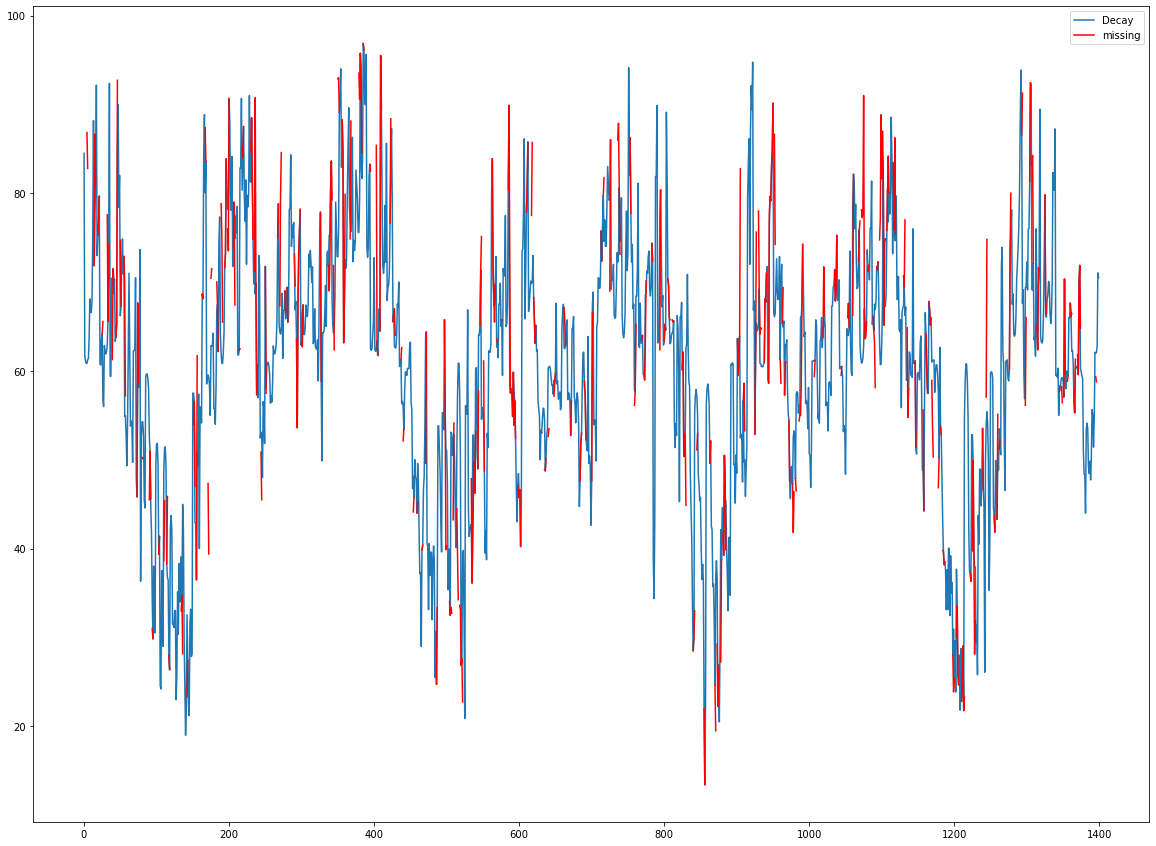

In [14]:
fig = plt.figure(figsize = (20, 15))
#plt.plot(climate.iloc[:,1],  label="truth")

#plt.plot(pca_data[10].iloc[:,1], label="PCA")
#plt.plot(sotimpute_data[1][:,1], label ="Softimpute")
plt.plot(pca_data_decay[1].iloc[:,1], label ="Decay")
#plt.plot(knn_data[10][:,1], label ="KNNImpute")
plt.plot(missing_data[0].iloc[:,1], label="missing", color="red")
plt.legend()

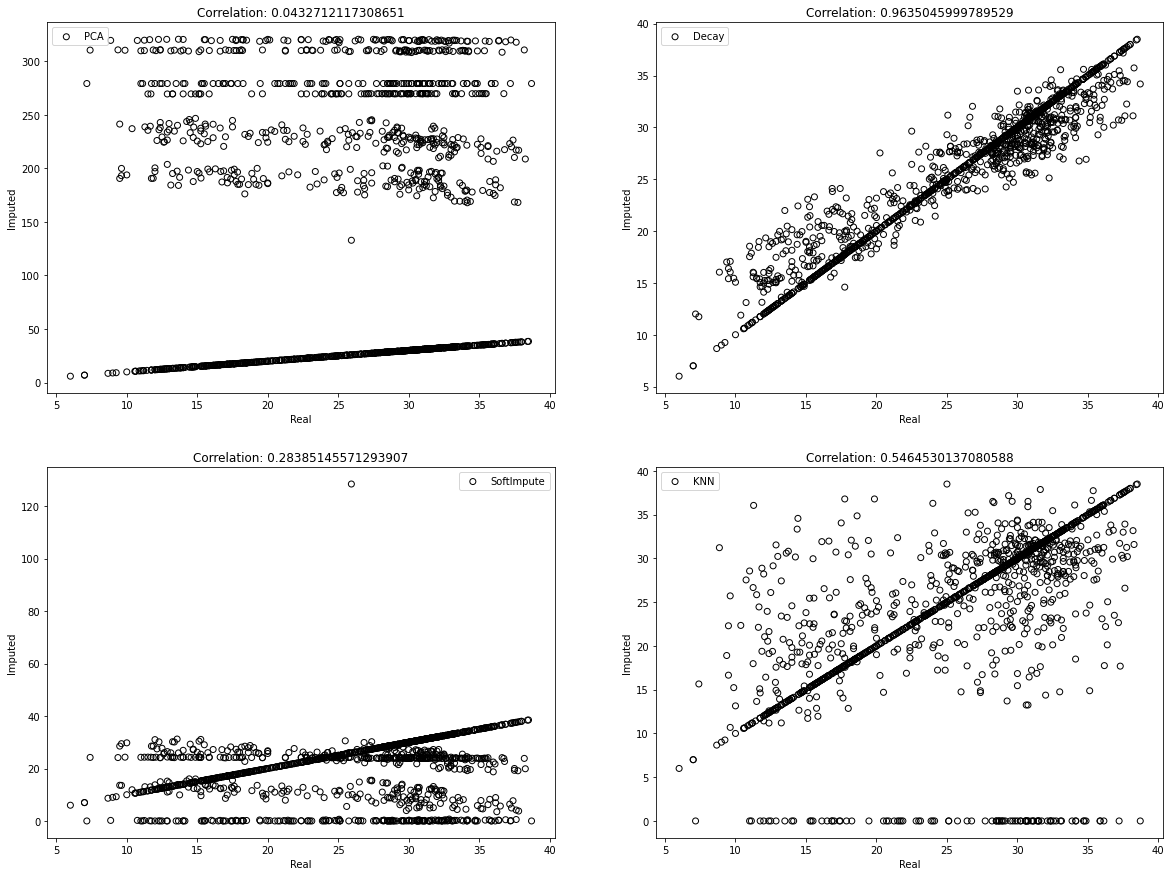

In [15]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2, figsize = (20, 15))
ax1.scatter(climate.iloc[:,0],pca_data[0].iloc[:,0], label="PCA", facecolors='none', edgecolors='black')
ax1.set_xlabel("Real")
ax1.set_ylabel("Imputed")
ax1.set_title(f'Correlation: {np.corrcoef(climate.iloc[:,0], pca_data[0].iloc[:,0])[0,1]}')
ax1.legend()
ax2.scatter(climate.iloc[:,0], pd.Series(pca_data_decay[0].iloc[:,0]), label="Decay", facecolors='none', edgecolors='black')
ax2.set_xlabel("Real")
ax2.set_ylabel("Imputed")
ax2.set_title(f'Correlation: {np.corrcoef(climate.iloc[:,0], pca_data_decay[0].iloc[:,0])[0,1]}')
ax2.legend()
ax3.scatter(climate.iloc[:,0], sotimpute_data[0][:,0], label="SoftImpute", facecolors='none', edgecolors='black')
ax3.set_xlabel("Real")
ax3.set_ylabel("Imputed")
ax3.set_title(f'Correlation: {np.corrcoef(climate.iloc[:,0], sotimpute_data[0][:,0])[0,1]}')
ax3.legend()
ax4.scatter(climate.iloc[:,0], knn_data[0][:,0], label="KNN", facecolors='none', edgecolors='black')
ax4.set_xlabel("Real")
ax4.set_ylabel("Imputed")
ax4.set_title(f'Correlation: {np.corrcoef(climate.iloc[:,0], knn_data[0][:,0])[0,1]}')
ax4.legend()

In [ ]:
%%capture
sotimpute_data = []
knn_data = []
pca_data = []
pca_data_decay = []
pca_mae = []
pca_mae_decay= []
knn_impute_mae = []
softimpute_mae = []
missing_data=[]

for iteration in range(0,10):
    rows = []
    for  row in baseketball_acc:
        #edge_nans = [np.nan for _ in range(200)]
        missing_middle = [np.nan if 1 < np.random.normal(1, 1, 1)[0] else 0 for i in range(5000)]

        #mask = [edge_nans, missing_middle, edge_nans]
        #shuffle(mask)
        #flat_list = [item for sublist in mask for item in sublist]
        rows.append(np.array(baseketball_acc[row].to_numpy()+missing_middle))
        
    
    missing_df = pd.DataFrame(rows).T
    missing_data.append(missing_df)
    softimpute = SoftImpute().fit_transform(missing_df)
    sotimpute_data.append(softimpute)

    PCA_fit_decay = TsSVD.fit(missing_df, rank=3)
    pca_data_decay.append(PCA_fit_decay.matrix)
    PCA_fit = TsSVD.fit(missing_df, rank=3, fill_with_decay=False)
    pca_data.append(PCA_fit.matrix)
    
    knn_imputed = KNN().fit_transform(missing_df)
    knn_data.append(knn_imputed)
    
        
    softimpute_mae.append(mean_absolute_error(baseketball_acc,  softimpute))
    pca_mae.append(mean_absolute_error(baseketball_acc, PCA_fit.matrix))
    pca_mae_decay.append(mean_absolute_error(baseketball_acc, PCA_fit_decay.matrix))
    knn_impute_mae.append(mean_absolute_error(baseketball_acc,  knn_imputed))

In [ ]:
print("Average MAE for PCA-EM",np.mean(pca_mae))
print("Average MAE for SoftImpute",np.mean(softimpute_mae))
print("Mean MAE for PCA-Decay", np.mean(pca_mae_decay))
print("Mean MAE for KNN Impute", np.mean(knn_impute_mae))

In [ ]:
fig = plt.figure(figsize = (20, 15))
plt.plot(baseketball_acc.iloc[:,1],  label="truth")

#plt.plot(pca_data[1].iloc[:,1], label="PCA")
#plt.plot(sotimpute_data[1][:,1], label ="Softimpute")
plt.plot(pca_data_decay[1].iloc[:,1], label ="Decay")
#plt.plot(knn_data[1][:,1], label ="KNNImpute")
plt.legend()

In [ ]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2, figsize = (20, 15))
ax1.scatter(baseketball_acc.iloc[:,1],pca_data[0].iloc[:,1], label="PCA", facecolors='none', edgecolors='black')
ax1.set_xlabel("Real")
ax1.set_ylabel("Imputed")
ax1.set_title(f'Correlation: {np.corrcoef(baseketball_acc.iloc[:,1], pca_data[0].iloc[:,1])[0,1]}')
ax1.legend()
ax2.scatter(baseketball_acc.iloc[:,1], pd.Series(pca_data_decay[0].iloc[:,1]), label="Decay", facecolors='none', edgecolors='black')
ax2.set_xlabel("Real")
ax2.set_ylabel("Imputed")
ax2.set_title(f'Correlation: {np.corrcoef(baseketball_acc.iloc[:,1], pca_data_decay[0].iloc[:,1])[0,1]}')
ax2.legend()
ax3.scatter(baseketball_acc.iloc[:,1], sotimpute_data[0][:,1], label="SoftImpute", facecolors='none', edgecolors='black')
ax3.set_xlabel("Real")
ax3.set_ylabel("Imputed")
ax3.set_title(f'Correlation: {np.corrcoef(baseketball_acc.iloc[:,1], sotimpute_data[0][:,1])[0,1]}')
ax3.legend()
ax4.scatter(baseketball_acc.iloc[:,1], knn_data[0][:,1], label="KNN", facecolors='none', edgecolors='black')
ax4.set_xlabel("Real")
ax4.set_ylabel("Imputed")
ax4.set_title(f'Correlation: {np.corrcoef(baseketball_acc.iloc[:,1], knn_data[0][:,1])[0,1]}')
ax4.legend()

In [ ]:
%%capture
sotimpute_data = []
knn_data = []
pca_data = []
pca_data_decay = []
pca_mae = []
pca_mae_decay= []
knn_impute_mae = []
softimpute_mae = []
missing_data=[]

for iteration in range(0,50):
    rows = []
    for  row in cycling:
        #edge_nans = [np.nan for _ in range(200)]
        missing_middle = [np.nan if 2 < np.random.normal(1, 1, 1)[0] else 0 for i in range(480)]

        #mask = [edge_nans, missing_middle, edge_nans]
        #shuffle(mask)
        #flat_list = [item for sublist in mask for item in sublist]
        rows.append(np.array(cycling[row].to_numpy()+missing_middle))
        
    
    missing_df = pd.DataFrame(rows).T
    missing_data.append(missing_df)
    softimpute = SoftImpute().fit_transform(missing_df)
    sotimpute_data.append(softimpute)

    PCA_fit_decay = TsSVD.fit(missing_df, rank=2)
    pca_data_decay.append(PCA_fit_decay.matrix)
    PCA_fit = TsSVD.fit(missing_df, rank=2, fill_with_decay=False)
    pca_data.append(PCA_fit.matrix)
    
    knn_imputed = KNN().fit_transform(missing_df)
    knn_data.append(knn_imputed)
    
        
    softimpute_mae.append(mean_absolute_error(cycling,  softimpute))
    pca_mae.append(mean_absolute_error(cycling, PCA_fit.matrix))
    pca_mae_decay.append(mean_absolute_error(cycling, PCA_fit_decay.matrix))
    knn_impute_mae.append(mean_absolute_error(cycling,  knn_imputed))

In [ ]:
print("Average MAE for PCA-EM",np.mean(pca_mae))
print("Average MAE for SoftImpute",np.mean(softimpute_mae))
print("Mean MAE for PCA-Decay", np.mean(pca_mae_decay))
print("Mean MAE for KNN Impute", np.mean(knn_impute_mae))

In [ ]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2, figsize = (20, 15))
ax1.scatter(cycling.iloc[:,1],pca_data[0].iloc[:,1], label="PCA", facecolors='none', edgecolors='black')
ax1.set_xlabel("Real")
ax1.set_ylabel("Imputed")
ax1.set_title(f'Correlation: {np.corrcoef(cycling.iloc[:,1], pca_data[0].iloc[:,1])[0,1]}')
ax1.legend()
ax2.scatter(cycling.iloc[:,1], pd.Series(pca_data_decay[0].iloc[:,1]), label="Decay", facecolors='none', edgecolors='black')
ax2.set_xlabel("Real")
ax2.set_ylabel("Imputed")
ax2.set_title(f'Correlation: {np.corrcoef(cycling.iloc[:,1], pca_data_decay[0].iloc[:,1])[0,1]}')
ax2.legend()
ax3.scatter(cycling.iloc[:,1], sotimpute_data[0][:,1], label="SoftImpute", facecolors='none', edgecolors='black')
ax3.set_xlabel("Real")
ax3.set_ylabel("Imputed")
ax3.set_title(f'Correlation: {np.corrcoef(cycling.iloc[:,1], sotimpute_data[0][:,1])[0,1]}')
ax3.legend()
ax4.scatter(cycling.iloc[:,1], knn_data[0][:,1], label="KNN", facecolors='none', edgecolors='black')
ax4.set_xlabel("Real")
ax4.set_ylabel("Imputed")
ax4.set_title(f'Correlation: {np.corrcoef(cycling.iloc[:,1], knn_data[0][:,1])[0,1]}')
ax4.legend()

In [ ]:
fig = plt.figure(figsize = (20, 15))
plt.plot(cycling.iloc[:,2],  label="truth")

#plt.plot(pca_data[1].iloc[:,1], label="PCA")
#plt.plot(sotimpute_data[1][:,2], label ="Softimpute")
plt.plot(pca_data_decay[1].iloc[:,2], label ="Decay")
plt.plot(knn_data[1][:,2], label ="KNNImpute")
plt.legend()

In [ ]:
%%capture
sotimpute_data = []
knn_data = []
pca_data = []
pca_data_decay = []
pca_mae = []
pca_mae_decay= []
knn_impute_mae = []
softimpute_mae = []
missing_data=[]

for iteration in range(0,50):
    rows = []
    for  row in standing:
        #edge_nans = [np.nan for _ in range(200)]
        missing_middle = [np.nan if 1 < np.random.normal(1, 1, 1)[0] else 0 for i in range(480)]

        #mask = [edge_nans, missing_middle, edge_nans]
        #shuffle(mask)
        #flat_list = [item for sublist in mask for item in sublist]
        rows.append(np.array(standing[row].to_numpy()+missing_middle))
        
    
    missing_df = pd.DataFrame(rows).T
    missing_data.append(missing_df)
    softimpute = SoftImpute().fit_transform(missing_df)
    sotimpute_data.append(softimpute)

    PCA_fit_decay = TsSVD.fit(missing_df, rank=2)
    pca_data_decay.append(PCA_fit_decay.matrix)
    PCA_fit = TsSVD.fit(missing_df, rank=2, fill_with_decay=False)
    pca_data.append(PCA_fit.matrix)
    
    knn_imputed = KNN().fit_transform(missing_df)
    knn_data.append(knn_imputed)
    
        
    softimpute_mae.append(mean_absolute_error(standing,  softimpute))
    pca_mae.append(mean_absolute_error(standing, PCA_fit.matrix))
    pca_mae_decay.append(mean_absolute_error(standing, PCA_fit_decay.matrix))
    knn_impute_mae.append(mean_absolute_error(standing,  knn_imputed))

In [ ]:
print("Average MAE for PCA-EM",np.mean(pca_mae))
print("Average MAE for SoftImpute",np.mean(softimpute_mae))
print("Mean MAE for PCA-Decay", np.mean(pca_mae_decay))
print("Mean MAE for KNN Impute", np.mean(knn_impute_mae))

In [ ]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2, figsize = (20, 15))
ax1.scatter(standing.iloc[:,1],pca_data[0].iloc[:,1], label="PCA", facecolors='none', edgecolors='black')
ax1.set_xlabel("Real")
ax1.set_ylabel("Imputed")
ax1.set_title(f'Correlation: {np.corrcoef(standing.iloc[:,1], pca_data[0].iloc[:,1])[0,1]}')
ax1.legend()
ax2.scatter(standing.iloc[:,1], pd.Series(pca_data_decay[0].iloc[:,1]), label="Decay", facecolors='none', edgecolors='black')
ax2.set_xlabel("Real")
ax2.set_ylabel("Imputed")
ax2.set_title(f'Correlation: {np.corrcoef(standing.iloc[:,1], pca_data_decay[0].iloc[:,1])[0,1]}')
ax2.legend()
ax3.scatter(standing.iloc[:,1], sotimpute_data[0][:,1], label="SoftImpute", facecolors='none', edgecolors='black')
ax3.set_xlabel("Real")
ax3.set_ylabel("Imputed")
ax3.set_title(f'Correlation: {np.corrcoef(standing.iloc[:,1], sotimpute_data[0][:,1])[0,1]}')
ax3.legend()
ax4.scatter(standing.iloc[:,1], knn_data[0][:,1], label="KNN", facecolors='none', edgecolors='black')
ax4.set_xlabel("Real")
ax4.set_ylabel("Imputed")
ax4.set_title(f'Correlation: {np.corrcoef(standing.iloc[:,1], knn_data[0][:,1])[0,1]}')
ax4.legend()

In [ ]:
fig = plt.figure(figsize = (20, 15))
plt.plot(standing.iloc[:,2],  label="truth")

#plt.plot(pca_data[1].iloc[:,1], label="PCA")
#plt.plot(sotimpute_data[1][:,2], label ="Softimpute")
plt.plot(pca_data_decay[1].iloc[:,2], label ="Decay")
plt.plot(knn_data[1][:,2], label ="KNNImpute")
plt.legend()

In [ ]:
%%capture
sotimpute_data = []
knn_data = []
pca_data = []
pca_data_decay = []
pca_mae = []
pca_mae_decay= []
knn_impute_mae = []
softimpute_mae = []
missing_data=[]

for iteration in range(0,2):
    rows = []
    for  row in motor_activity:
        #edge_nans = [np.nan for _ in range(200)]
        missing_middle = [np.nan if 0.5 < np.random.normal(1, 1, 1)[0] else 0 for i in range(1000)]

        #mask = [edge_nans, missing_middle, edge_nans]
        #shuffle(mask)
        #flat_list = [item for sublist in mask for item in sublist]
        rows.append(np.array(motor_activity[row].to_numpy()+missing_middle))
        
    
    missing_df = pd.DataFrame(rows).T
    missing_data.append(missing_df)
    softimpute = SoftImpute().fit_transform(missing_df)
    sotimpute_data.append(softimpute)

    PCA_fit_decay = TsSVD.fit(missing_df, rank=2)
    pca_data_decay.append(PCA_fit_decay.matrix)
    PCA_fit = TsSVD.fit(missing_df, rank=2, fill_with_decay=False)
    pca_data.append(PCA_fit.matrix)
    
    knn_imputed = KNN().fit_transform(missing_df)
    knn_data.append(knn_imputed)
    
        
    softimpute_mae.append(mean_absolute_error(motor_activity,  softimpute))
    pca_mae.append(mean_absolute_error(motor_activity, PCA_fit.matrix))
    pca_mae_decay.append(mean_absolute_error(motor_activity, PCA_fit_decay.matrix))
    knn_impute_mae.append(mean_absolute_error(motor_activity,  knn_imputed))

In [ ]:
print("Average MAE for PCA-EM",np.mean(pca_mae))
print("Average MAE for SoftImpute",np.mean(softimpute_mae))
print("Mean MAE for PCA-Decay", np.mean(pca_mae_decay))
print("Mean MAE for KNN Impute", np.mean(knn_impute_mae))

In [ ]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2, figsize = (20, 15))
ax1.scatter(motor_activity.iloc[:,1],pca_data[0].iloc[:,1], label="PCA", facecolors='none', edgecolors='black')
ax1.set_xlabel("Real")
ax1.set_ylabel("Imputed")
ax1.set_title(f'Correlation: {np.corrcoef(motor_activity.iloc[:,1], pca_data[0].iloc[:,1])[0,1]}')
ax1.legend()
ax2.scatter(motor_activity.iloc[:,1], pd.Series(pca_data_decay[0].iloc[:,1]), label="Decay", facecolors='none', edgecolors='black')
ax2.set_xlabel("Real")
ax2.set_ylabel("Imputed")
ax2.set_title(f'Correlation: {np.corrcoef(motor_activity.iloc[:,1], pca_data_decay[0].iloc[:,1])[0,1]}')
ax2.legend()
ax3.scatter(motor_activity.iloc[:,1], sotimpute_data[0][:,1], label="SoftImpute", facecolors='none', edgecolors='black')
ax3.set_xlabel("Real")
ax3.set_ylabel("Imputed")
ax3.set_title(f'Correlation: {np.corrcoef(motor_activity.iloc[:,1], sotimpute_data[0][:,1])[0,1]}')
ax3.legend()
ax4.scatter(motor_activity.iloc[:,1], knn_data[0][:,1], label="KNN", facecolors='none', edgecolors='black')
ax4.set_xlabel("Real")
ax4.set_ylabel("Imputed")
ax4.set_title(f'Correlation: {np.corrcoef(motor_activity.iloc[:,1], knn_data[0][:,1])[0,1]}')
ax4.legend()

In [ ]:
fig = plt.figure(figsize = (20, 15))
plt.plot(motor_activity.iloc[:,1],  label="truth")

#plt.plot(missing_data[1].iloc[:,1], label="Missing")
#plt.plot(sotimpute_data[1][:,2], label ="Softimpute")
plt.plot(pca_data_decay[1].iloc[:,1], label ="Decay")
#plt.plot(knn_data[1][:,2], label ="KNNImpute")
plt.legend()